# Training an AutoODE model

In [1]:
using NODEData
using Optimisers, Flux
using Printf, Dates, Statistics
using Plots

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\colin\.julia\packages\Flux\Wz6D4\ext\FluxCUDAExt\FluxCUDAExt.jl:57


In [2]:
using MMDS

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\colin\.julia\packages\Flux\Wz6D4\ext\FluxCUDAExt\FluxCUDAExt.jl:57


### Data and Dataloader
- defining the data source
- loading the data as sequences

In [3]:
# data
N_states = 56    # pick a subset of states to speed up training
data_dir = "../../covid_data/csse_covid_19_data/csse_covid_19_daily_reports_us"
pop_file = "../../AutoODE-DSL/ode_nn/population_states.csv"
dates, states, population, I, R, D = get_covid_IRD(data_dir; normalize=pop_file)
covid_data, t_covid = prepare_data(I, R, D; N_states=N_states)
print("data: $(covid_data |> summary) \nt:    $(t_covid |> summary)")

data: 56×3×1062 Array{Float64, 3} 
t:    1062-element UnitRange{Int64}

In [4]:
# dataloader
L_train = 10        # input sequence length
L_pred = 7          # prediction horizon

dataloader = NODEDataloader(covid_data, t_covid, L_train+L_pred)
# dataloader = NODEDataloader(covid_data |> f32, t_covid, L_train+L_pred)

NODEData{Array{Float64, 3},Int64} with 1046 batches with length 17

## AutoODE

In [5]:
# choose sample on which to train
train_idx = 131
sample_train = dataloader[train_idx]
t_train, x_train, t, x = split_sample(sample_train, L_train)

([130, 131, 132, 133, 134, 135, 136, 137, 138, 139], [0.023059557381351285 0.009139796712954052 0.00040376776276455326; 0.006191841402147228 0.002049946617384848 3.929177257380079e-5; … ; 0.011727814599017644 0.010153919294938904 0.00018339481155968263; 0.006025587394547864 0.00493620581468312 5.926235794464198e-5;;; 0.02336125821725692 0.009139796712954052 0.00040826770743568813; 0.006278554279551479 0.002169176823815692 4.06466612832422e-5; … ; 0.011869786589971999 0.010322188761215314 0.00018356669048335617; 0.006142369099909363 0.004991982151572195 6.449138952799275e-5;;; 0.023483370352196352 0.009139796712954052 0.00041133585152964365; 0.006400494263401205 0.0022843423641182117 4.2001549992683605e-5; … ; 0.012033071567461875 0.010473098456200694 0.0001858011164911124; 0.006175486299937252 0.005018127309488949 6.449138952799275e-5;;; 0.02362164137936395 0.009139796712954052 0.00041174493740883775; 0.006488562029514896 0.0023642807979752547 4.335643870212501e-5; … ; 0.01211093271988

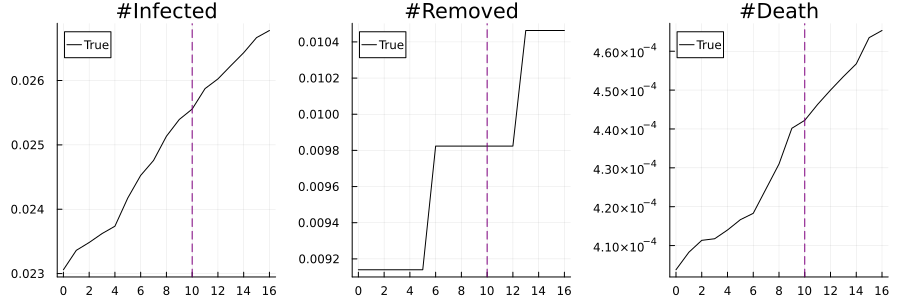

In [6]:
# visualize the chosen sequence
plot_sequence(x, state_index=1, L_train=L_train)

In [7]:
# model
# st_sueir = AutoODE_ST_SuEIR(x[:, :, 1])     # initialize model with y₀
st_sueir = ST_SuEIR(x[:, :, 1])     # initialize model with y₀
# st_sueir = ST_SuEIR(st_sueir.y₀, st_sueir.u₀, st_sueir.θ, st_sueir.q, f_ST_SuEIR2)
# model = ChaoticNDE(st_sueir)                # wrap model in ChaoticNDE
re_st_sueir, model = wrap_model(st_sueir, maxiters=Int(1e7))

# enrich input sequence with trainable initial conditions

# x_augm = augment_sample(st_sueir, x_train)
x_augm = augment_sample(re_st_sueir, model, x_train)
size(x_augm), typeof(x_augm)

((56, 6, 1), Array{Float64, 3})

In [8]:
# initialize the model
model((t_train, x_augm)) |> summary

"56×6×10 Array{Float64, 3}"

In [9]:
# save initial conditions to check training progress later
u₀_pre = deepcopy(st_sueir.u₀)
y₀_pre = deepcopy(st_sueir.y₀)
θ_pre = deepcopy(st_sueir.θ)
q_pre = deepcopy(st_sueir.q)

p_pre = deepcopy(model.p);

In [ ]:
## training params

# number of epochs
# N_epochs = 20_000
N_epochs = 2_000
# N_epochs = 4

# optimizer
global η = 0.01
optim = Optimisers.setup(Flux.Adam(η), model)

# loss function
# loss(ŷ, y, t) = loss_covid(ŷ, y, t)
loss(ŷ, y, t) = Flux.mse(ŷ, y)

In [10]:
# initialize the gradient
loss_train, grads = Flux.withgradient(model) do m
    x_augm = augment_sample(re_st_sueir, m, x_train)
    pred = m((t_train, x_augm))
    pred_IRD = pred[:, 4:6, :]
    return loss(pred_IRD, x_train, t_train)
end

UndefVarError: UndefVarError: `loss` not defined

In [ ]:
using ProgressMeter
@showprogress for i_e = 1:N_epochs
    sleep(2)

In [1]:
# training loop

pred_val_init = model((t, x_augm))

losses_train = zeros(N_epochs)
losses_val = zeros(N_epochs)
params_history = zeros(N_epochs, length(model.p))
t0_train = now()
for i_e = 1:N_epochs

    t0_epoch = now()

    loss_train, grads = Flux.withgradient(model) do m
        x_augm = augment_sample(re_st_sueir, m, x_train)
        pred = m((t_train, x_augm))
        pred_IRD = pred[:, 4:6, :]
        return loss(pred_IRD, x_train, t_train)
    end
    t1_epoch = now()
    Flux.update!(optim, model, grads[1])
    t2_epoch = now()

    params_history[i_e, :] = model.p

    # collect loss metric
    losses_train[i_e] = loss_train

    if (i_e % 20) == 0  # reduce the learning rate every 20
        global η /= 2
        Optimisers.adjust!(optim, η)
    end
    if (i_e % 1) == 0  # log training progress
        # @info """Epoch $i_e \t train loss = $(@sprintf("%5.3f", loss_train))   η = $η   t = $(t2_epoch-t0_epoch)   t_avg = $(typeof(now()-t0_train)(Int(round((now()-t0_train).value/i_e))))"""
        # @info """Times  t_epoch = $(t2_epoch-t0_epoch)    t_fwd = $(t1_epoch-t0_epoch)   t_bckwd = $(t2_epoch-t1_epoch)"""
    end

    # "validation"
    if (i_e % 1) == 0  # calculate loss for validation set?
        global pred_val = model((t, x_augm))
        pred_val_IRD = pred_val[:, 4:6, :]
        loss_val = loss(pred_val_IRD, x, t)
        losses_val[i_e] = loss_val
        # @info """\t\t val   loss = $(@sprintf("%5.3f", loss_val))"""
    end
end

println("Finished training $N_epochs epochs after $(now()-t0_train) ($(typeof(now()-t0_train)(Int(round((now()-t0_train).value/N_epochs))))/epoch)")

UndefVarError: UndefVarError: `t` not defined

In [17]:
# save model training
save_params(model, "checkpoints.jld")

## Training Sanity Check
Plot quantities to confirm that the learnable parameters are actually changing.

- plot training and validation loss over time
- plot values of subset of parameters over time
- confirm that trainable initial conditions $u_0$ are properly learned
- confirm that known initial conditions remain constant
- confirm that trainable parameters $\theta$ are learning

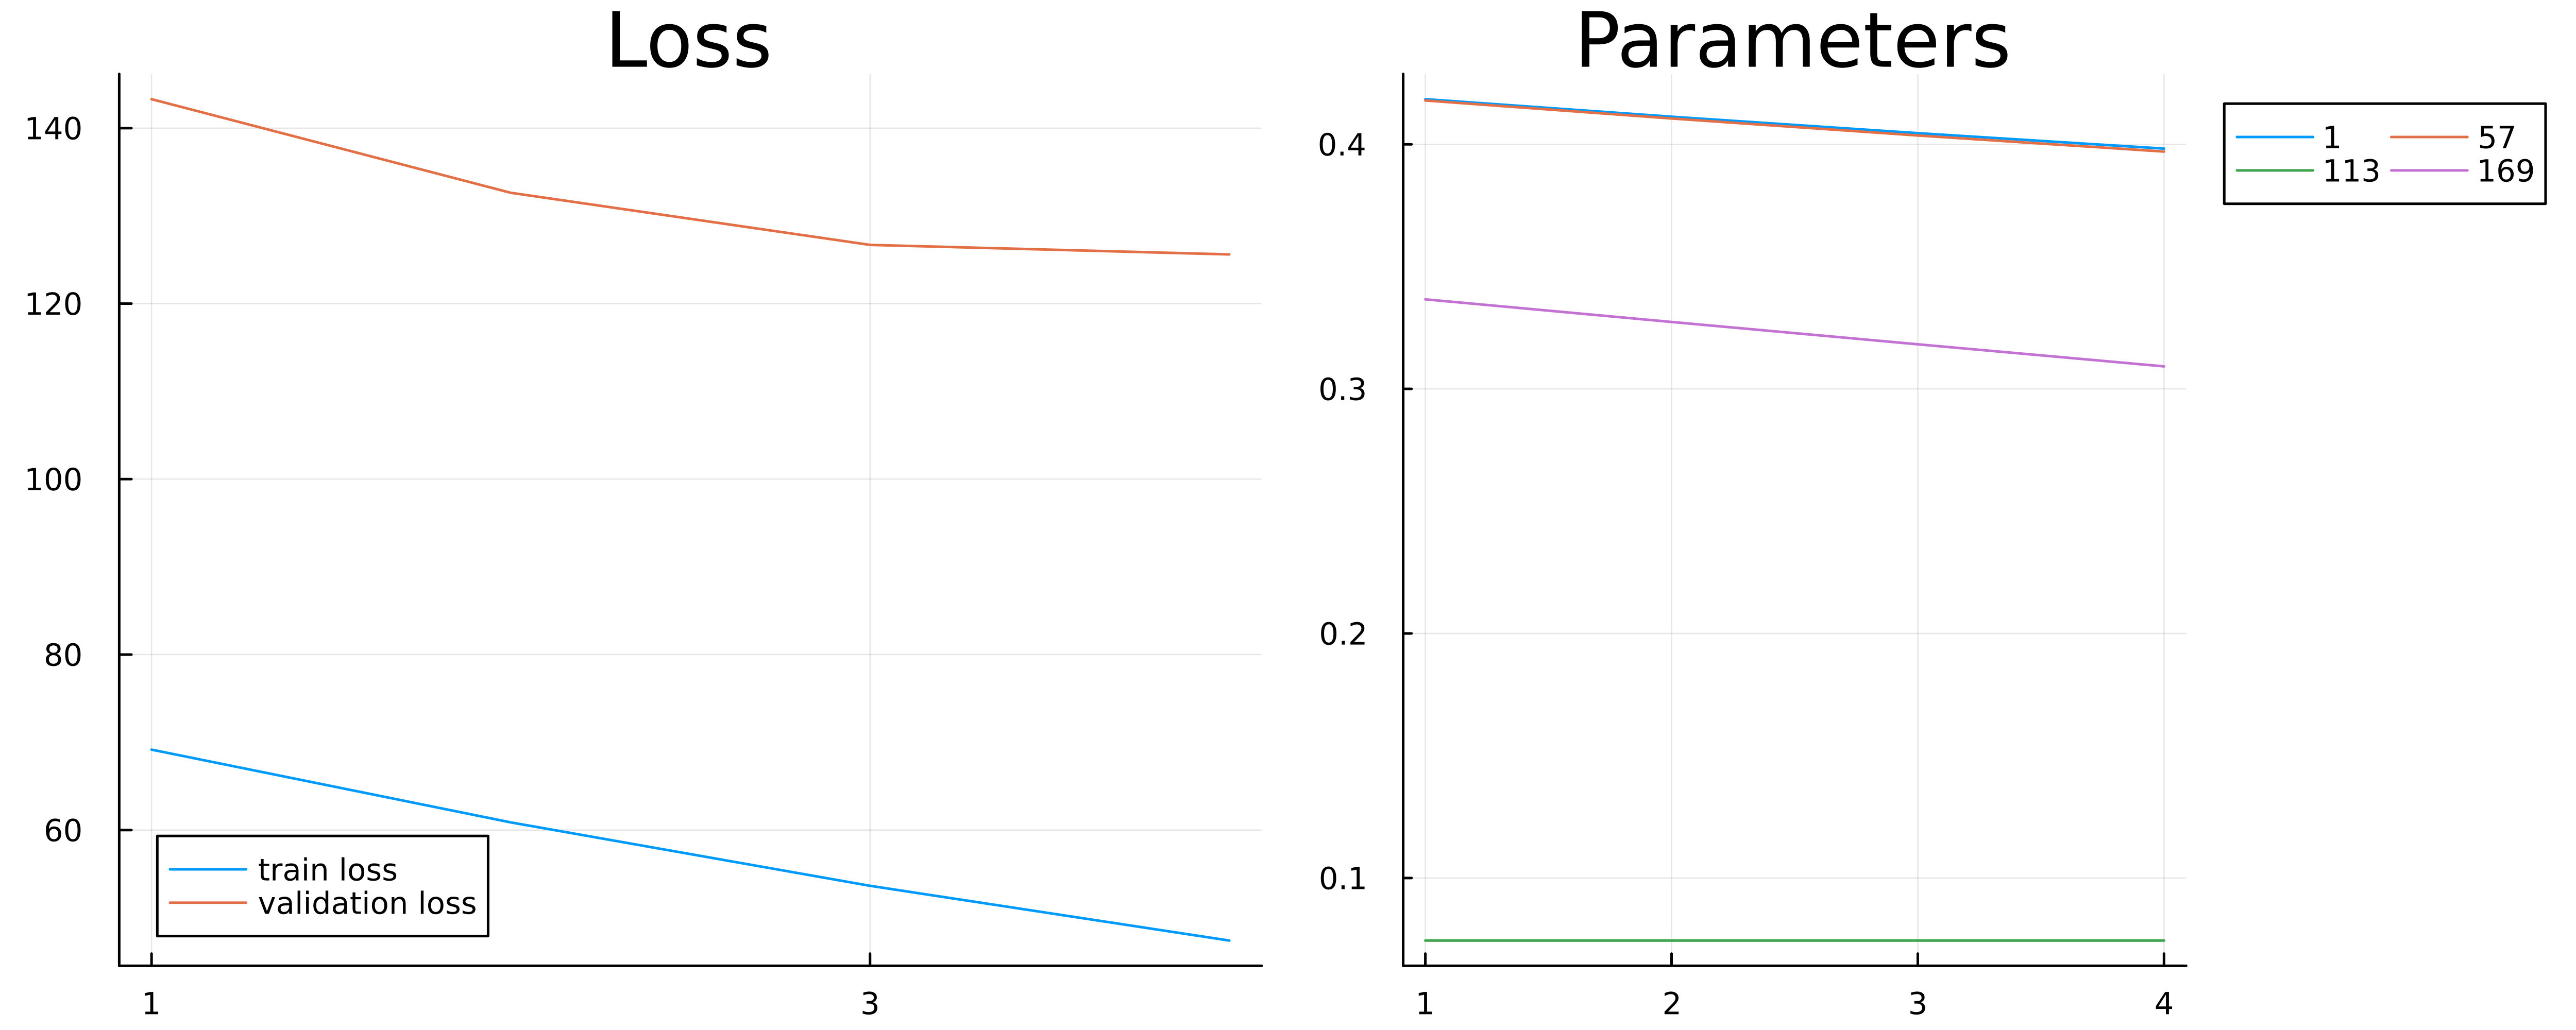

In [26]:
# plot training progress

pick_params = [1, N_states+1, N_states*2+1, N_states*3+1]

plt1 = plot(1:N_epochs, losses_train, label="train loss")
plot!(title="Loss", titlefont=font(20), xticks=1:2:N_epochs)
plot!(1:N_epochs, losses_val, label="validation loss")
plt2 = plot(1:N_epochs, params_history[:, pick_params], label=pick_params')
# plt2 = plot(1:N_epochs, params_history[:, pick_params], label=(1:length(model.p))')
plot!(title="Parameters", titlefont=font(20), legend=:outertopright, legend_column=2)
plot(plt1, plt2, layout=(1,2), dpi=500, size=(1000, 400))

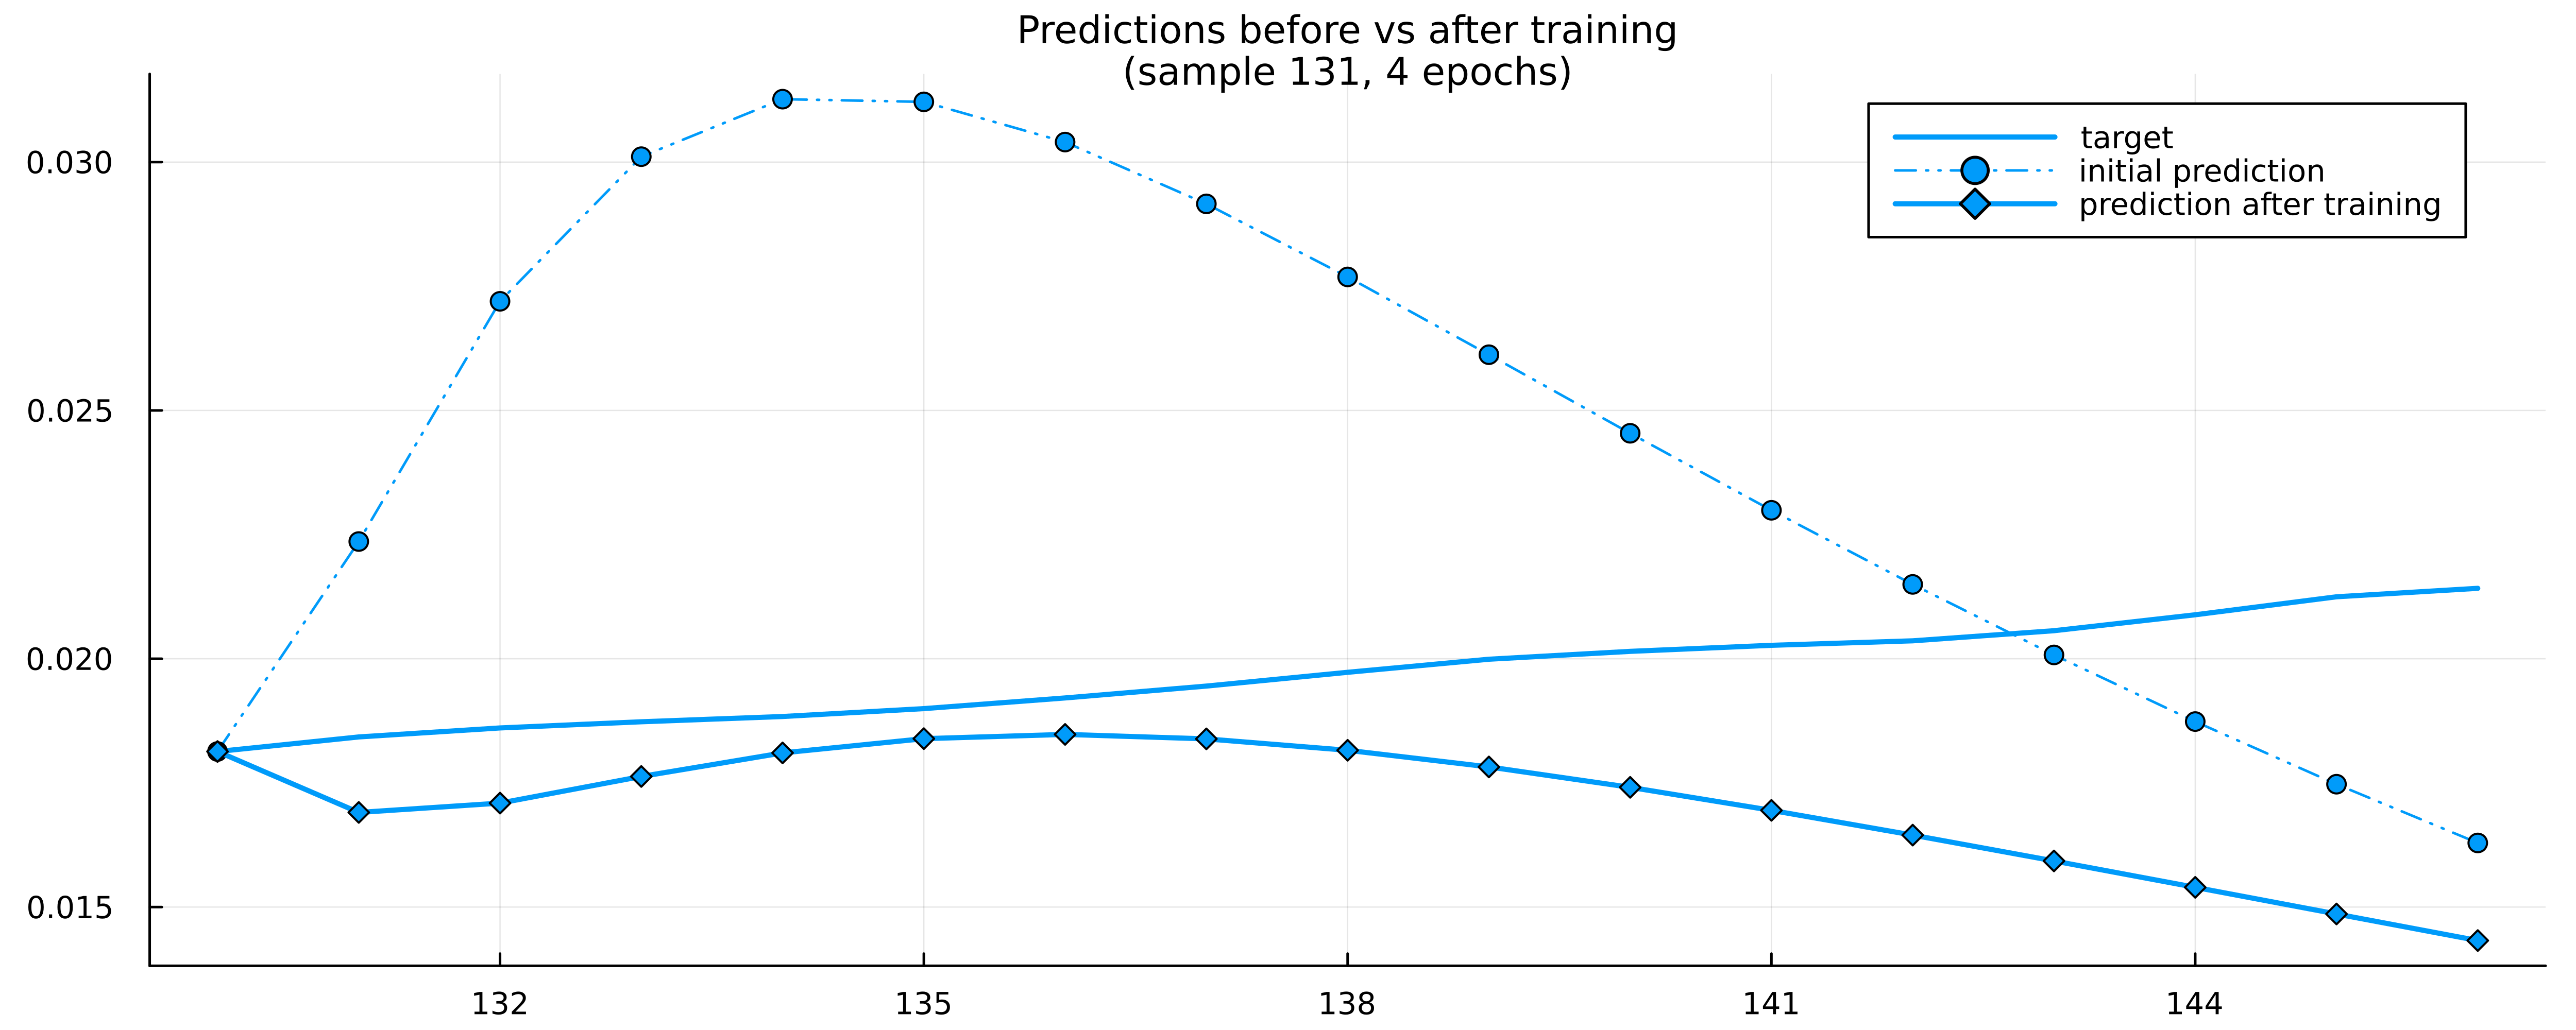

In [56]:
# test sample after training and plot
plot_states = 5
plot_variables = [1]
colors = palette(:default)[1:size(pred_val, 2)]'
plt3 = plot(sample_train[1], sample_train[2][plot_states, plot_variables, :]', lw=2,label="target", color=colors)
plot!(sample_train[1], pred_val_init[plot_states, 3 .+ plot_variables, :]', ls=:dashdotdot, label="initial prediction", color=colors, marker=:circle)
plot!(sample_train[1], pred_val[plot_states, 3 .+ plot_variables, :]', lw=2, label="prediction after training", color=colors, marker=:diamond)
plot!(title="Predictions before vs after training\n(sample $train_idx, $N_epochs epochs)", titlefont=font(10), dpi=500, size=(1000, 400))

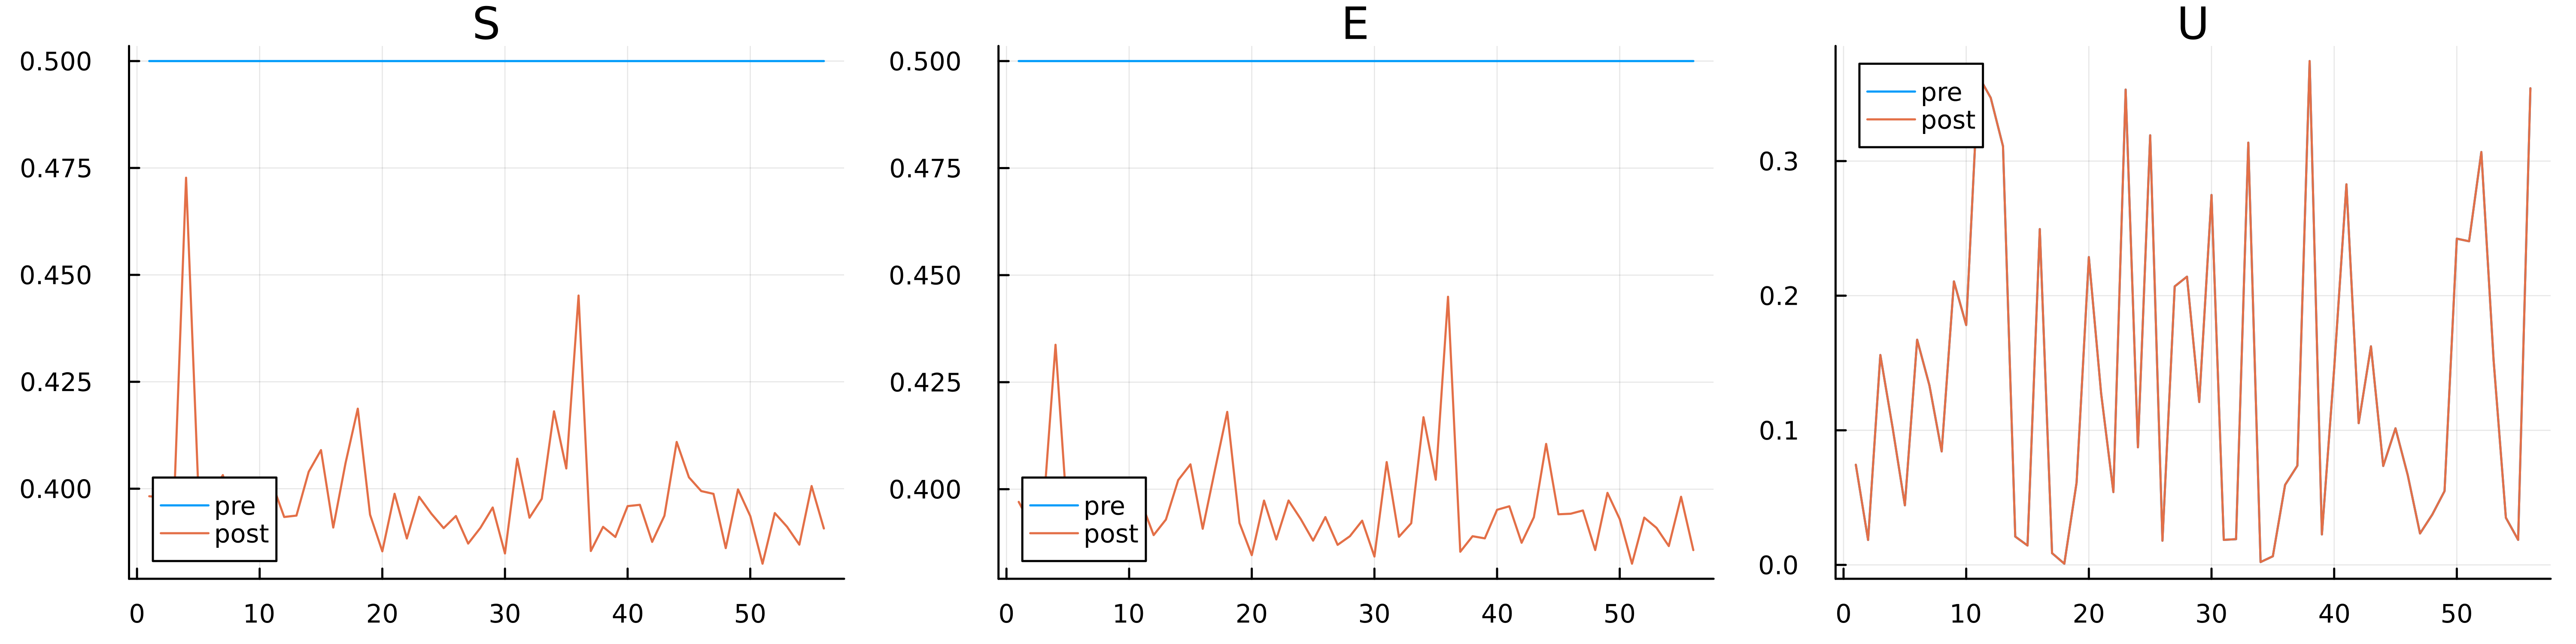

In [61]:
# plot initial conditions
l = @layout [a b c]
plot(u₀_pre, label="pre", title=["S" "E" "U"], layout=l, xlabel="states")
# u₀_post = st_sueir.u₀
u₀_post = re_st_sueir(model.p).u₀
plot!(u₀_post, label="post", dpi=500, size=(1200, 300))

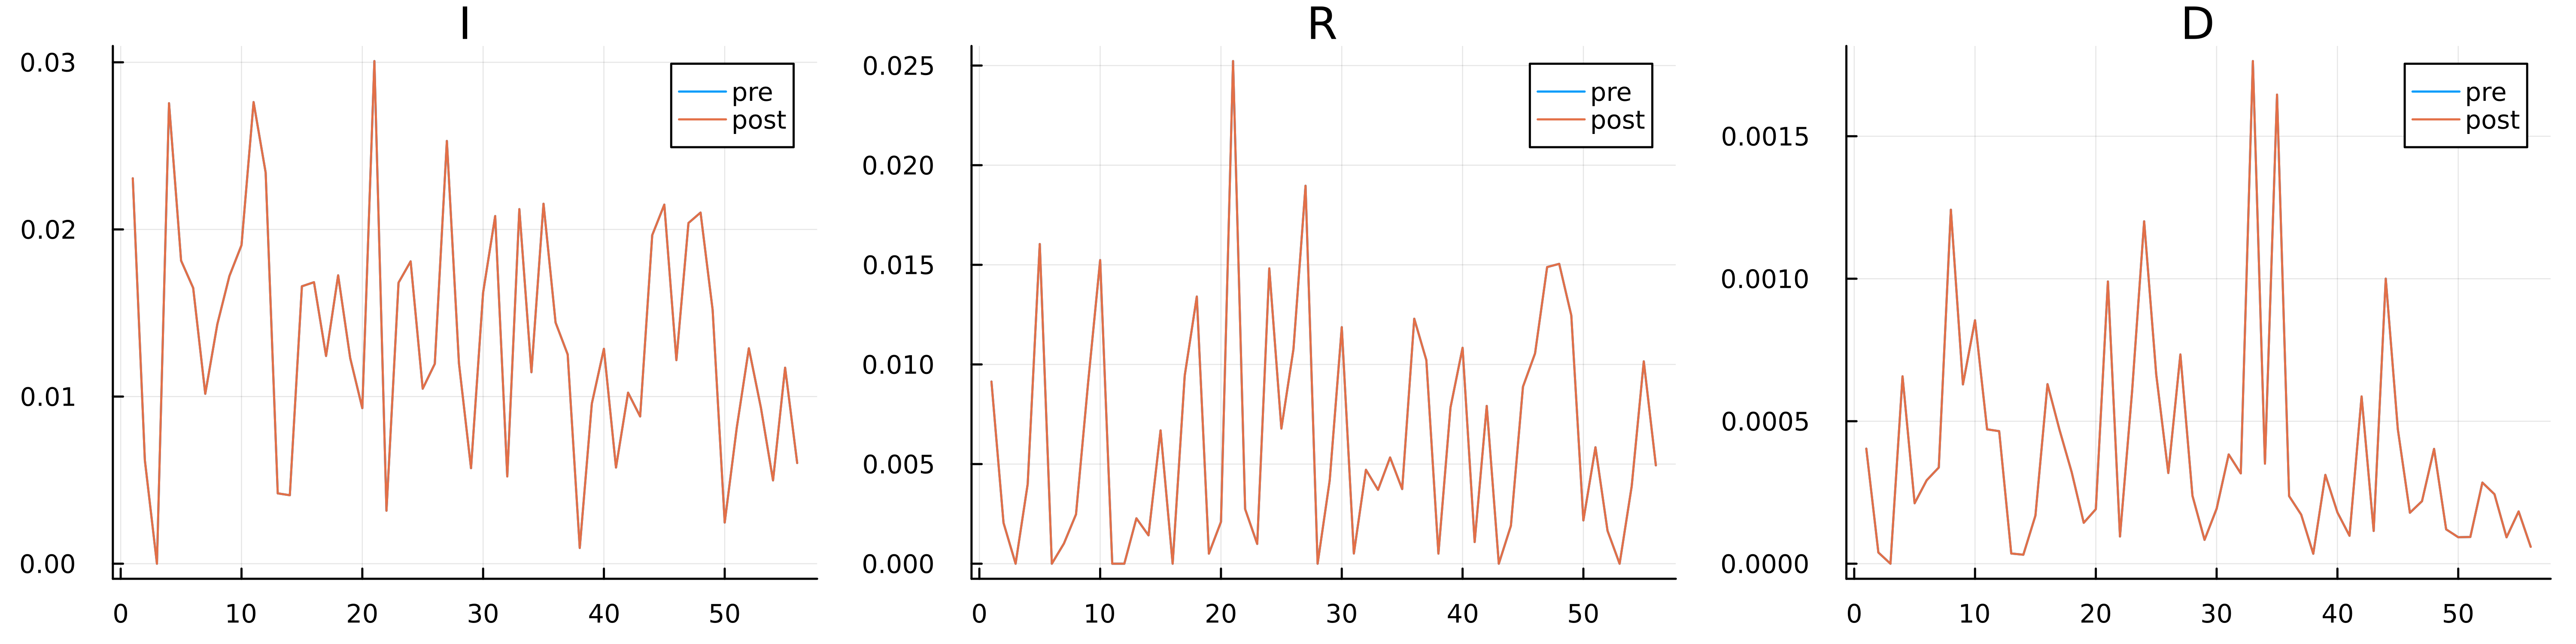

In [62]:
# plot constant initial conditions -> should not change
l = @layout [a b c]
plot(y₀_pre, label="pre", title=["I" "R" "D"], layout=l, xlabel="states")
y₀_post = st_sueir.y₀
y₀_post = re_st_sueir(model.p).y₀
plot!(y₀_post, label="post", dpi=500, size=(1200, 300))

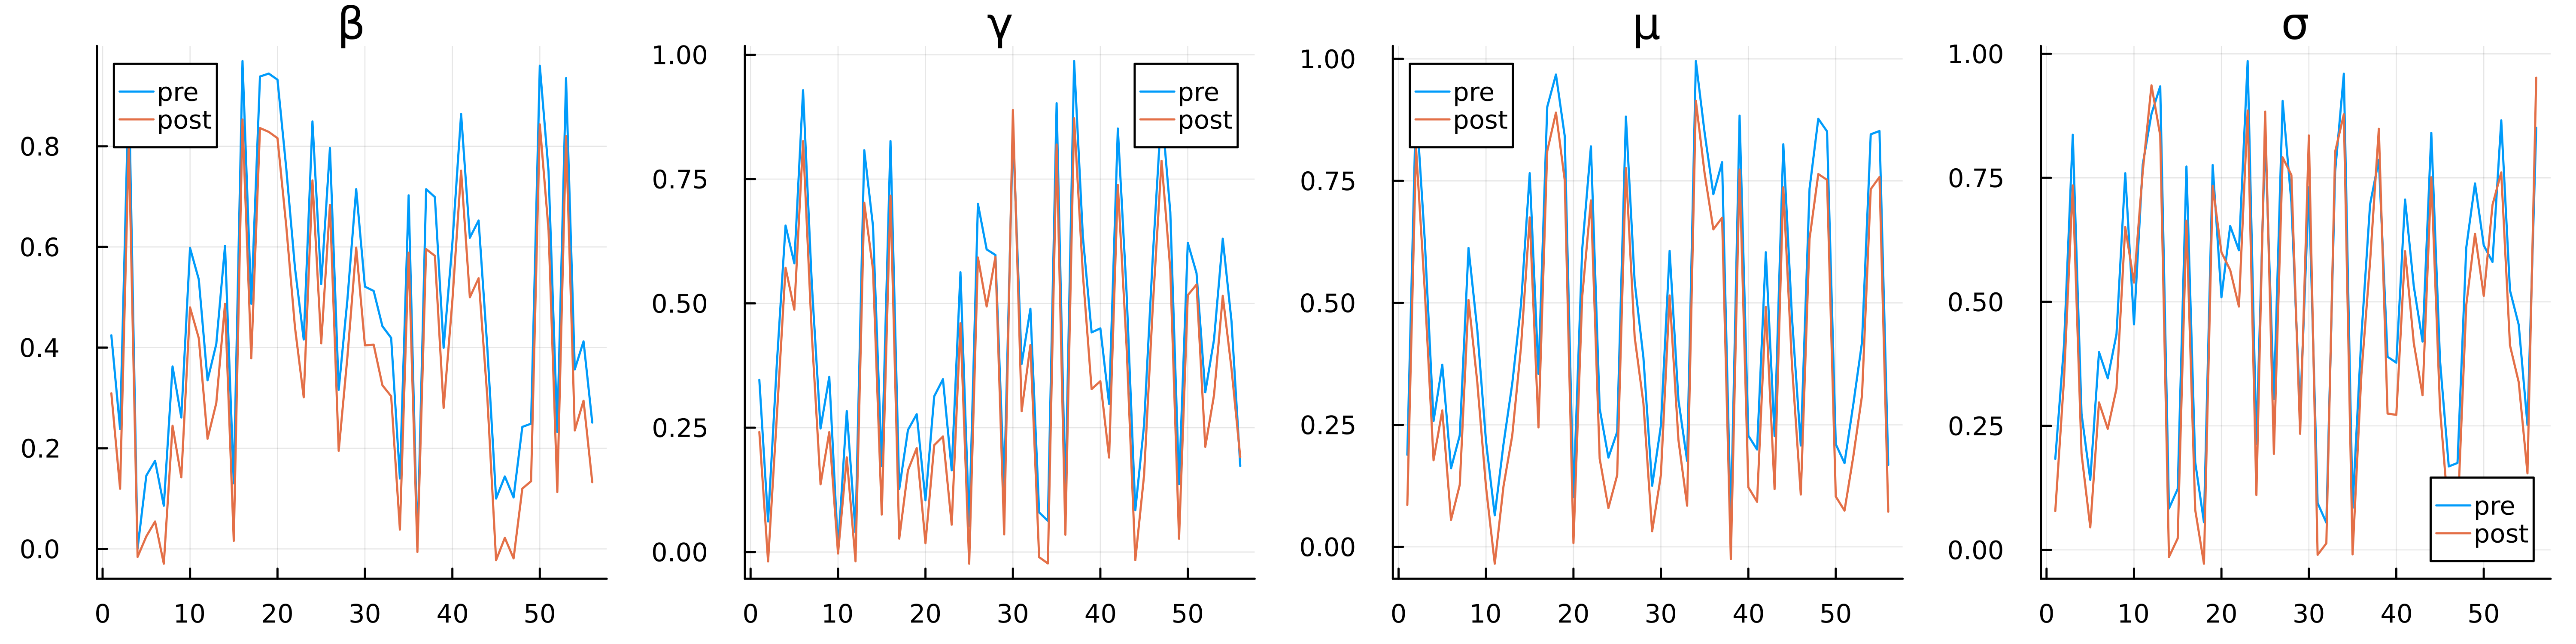

In [63]:
# plot some parameters
params = ["β" "γ" "μ" "σ" "a" "b" "A"]
β, γ, μ, σ, a, b, A = θ_pre

pick_params = [1, 2, 3, 4]

plot(θ_pre[pick_params], label="pre", title=reshape(params[pick_params], 1, :), layout = (1, length(pick_params)), xlabel="states")
# θ_post = st_sueir.θ
θ_post = re_st_sueir(model.p).θ
plot!(θ_post[pick_params], dpi=500, label="post", size=(1200, 300))

## NeuralODE

## Visualization

In [45]:

function plot_sequence(u_true, û...; state_index=1, t=nothing, labels=nothing, colors=nothing, L_train=nothing, height=300, kwargs...)
    # if size(u_true, 2) == 6
    #     u_true = u_true[:, 4:6, :]
    # end

    t = isnothing(t) ? (0:size(u_true, ndims(u_true))-1) : t
    labels = isnothing(labels) ? ["model $i" for i in 1:length(û)] : labels
    colors = isnothing(colors) ? palette(:default)[1:length(û)]' : colors
    vlines = isnothing(L_train) ? [] : (L_train isa Array ? L_train : [L_train])

    l = @layout [a b c]

    plt1 = plot(t, u_true[state_index, 1, :], color="black", label="True")
	for (û_, label, color) in zip(û, labels, colors)
		plot!(t, û_[state_index, 1, :], color=color, ls=:dash, label=label)
        vline!(vlines, label=nothing)
	end
    plot!(title="#Infected", xticks=t[1:2:end])

    plt2 = plot(t, u_true[state_index, 2, :], color="black", label="True")
	for (û_, label, color) in zip(û, labels, colors)
        plot!(t, û_[state_index, 2, :], color=color, ls=:dash, label=label)
        vline!(vlines, label=nothing)
	end
    plot!(title="#Removed", xticks=t[1:2:end])

    plt3 = plot(t, u_true[state_index, 3, :], color="black", label="True")
	for (û_, label, color) in zip(û, labels, colors)
        plot!(t, û_[state_index, 3, :], color=color, ls=:dash, label=label)
        vline!(vlines, label=nothing)
	end
    plot!(title="#Death", xticks=t[1:2:end])

    plot(plt1, plt2, plt3, layout=l, size = (3*height, height), kwargs...)
end


plot_sequence (generic function with 1 method)

In [48]:
pred_st_sueir = model((t, x_augm))
a = plot_sequence(x_train, pred_st_sueir, labels=["ST-SuEIR"], L_train=L_train)

In [44]:
pred_st_sueir = model((t, x_augm))
plot_sequence(x, pred_st_sueir, labels=["ST-SuEIR"], t=t)

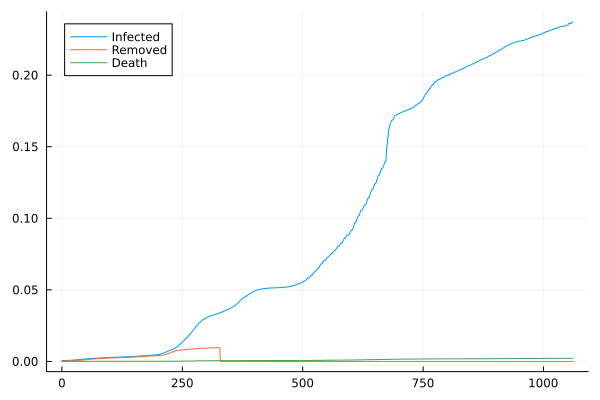

In [47]:
# visualize the data
state_idx = 22
plot(0:size(I, 2)-1, I[state_idx, :], label="Infected")
plot!(0:size(I, 2)-1, R[state_idx, :], label="Removed")
# plot!(twinx(), R[state_idx, :], label="Removed")
plot!(0:size(I, 2)-1, D[state_idx, :], label="Death")

In [6]:
module myModule
using Flux

import ..Main.AbstractNeuralODEModel
"""
A simple neural ODE as coined by [Chen et al.: Neural Differential Equations](TODO: link).
Models the RHS of an ODE by means of a neural network. Can be used by general ODE solvers.
"""
struct SimpleNeuralODE <: AbstractNeuralODEModel

    dims::AbstractArray{Int}

    chain::Flux.Chain

    # default constructor
    function SimpleNeuralODE(dims::AbstractArray{Int}; hidden_dims::AbstractArray{Int}=[128, 256, 512, 256, 128], σ::Function=Flux.relu)
        chain = Chain(
            Dense(prod(dims) => hidden_dims[1]), σ,
            [Flux.Chain(Dense(in => out), σ) for (in, out) in zip(hidden_dims[1:end-1], hidden_dims[2:end])]...,
            Dense(hidden_dims[end] => prod(dims))
        ) |> f64

        return new(dims, chain)
    end

    # constructor for restructuring
    function SimpleNeuralODE(dims::AbstractArray{Int}, chain::Flux.Chain)
        return new(dims, chain)
    end
end

@Flux.layer SimpleNeuralODE trainable=(chain,)

flatten_all(x) = reshape(x, :)

# TODO: reshape supported by Zygote?

function (s::SimpleNeuralODE)(x; flatten=true)
    if flatten
        x = flatten_all(x)
    end
    pred = s.chain(x)
    return reshape(pred, s.dims...)
end

# forward
function (s::SimpleNeuralODE)(x, t; flatten=true)
    if flatten
        x = flatten_all(x)
    end
    pred = s.chain(x)
    return reshape(pred, s.dims...)
end

end


Main.myModule

In [26]:
using DifferentialEquations

function ChaoticNDE(model::M; alg=RK4(), kwargs...) where {M <: Union{AbstractAutoODEModel, AbstractNeuralODEModel}}
    # initialize underlying Flux model and destructure
    p, re = destructure(model)

    # restructure and define ODEProblem
    ode(u, p, t) = re(p)(u, t)

    # T = typeof(model.y₀[1])
    T = Float64
    _tspan = (T(0), T(1))  # dummy tspan, not used TODO: type
    prob = ODEProblem(ode, [], _tspan, p)

    # wrap in ChaoticNDE
    return ChaoticNDE(prob; alg=alg, kwargs...)
end

ChaoticNDE

In [9]:
covid_data |> summary

"56×3×1062 Array{Float64, 3}"

In [30]:
train_set, val_set = NODEDataloader(covid_data, t_covid, L_train+L_pred, valid_set=0.2)

# dummy dataset for development
N_subset = 4
train_set = [dataloader[i] for i in 1:N_subset]
val_set = [dataloader[i+N_subset] for i in 1:N_subset]

s_neural = myModule.SimpleNeuralODE(collect(size(train_set[1][2][:, :, 1])))
model_neural = ChaoticNDE(s_neural)

N_epochs_neural = 2

global η_neural = 0.01
optim_neural = Optimisers.setup(Flux.Adam(η_neural), model_neural)

loss_neural(pred, gt, t) = Flux.mse(pred, gt)


loss_neural (generic function with 1 method)

In [ ]:
# initialize model
model_neural(train_set[1])

In [ ]:
# initialize gradients
loss_train, grads = Flux.withgradient(model_neural) do m
    pred = m((t_train_, x_train_))
    return loss_neural(pred, x_train_, t_train_)
end

In [31]:
train_losses = zeros(N_epochs_neural)
val_losses = zeros(N_epochs_neural)

for i_e in range(1, N_epochs_neural)

    train_losses_ = zeros(length(train_set))
    val_losses_ = zeros(length(val_set))

    # loop through train samples
    for (i_seq, (t_train_, x_train_)) in enumerate(train_set)

        loss_train, grads = Flux.withgradient(model_neural) do m
            pred = m((t_train_, x_train_))
            return loss_neural(pred, x_train_, t_train_)
        end
        Flux.update!(optim_neural, model_neural, grads[1])

        train_losses_[i_seq] = loss_train
    end


    if (i_e % 20) == 0  # reduce the learning rate every 20
        global η_neural /= 2
        Optimisers.adjust!(optim_neural, η_neural)
    end

    train_losses_avg = mean(train_losses_)
    train_losses[i_e] = train_losses_avg
    @info """Epoch $i_e \t train loss = $(@sprintf("%5.3f", train_losses_avg))   η = $η_neural"""

    # loop through validation samples
    for (i_seq, (t_val_, x_val_)) in enumerate(val_set)
        pred_val = model_neural((t_val_, x_val_))
        loss_val = loss(pred_val, x_val_, t_val_)
        val_losses_[i_seq] = loss_val
    end

    loss_val_avg = mean(val_losses_)
    losses_val[i_e] = loss_val_avg
    @info """\t\t val   loss = $(@sprintf("%5.3f", loss_val_avg))"""
end

┌ Info: Epoch 1 	 train loss = 26.471   η = 0.01
└ @ Main c:\Users\colin\OneDrive-TUM\Code\Julia\MMDS.jl\scripts\AutoODE_train_test.ipynb:31


UndefVarError: UndefVarError: `m` not defined